In [1]:
import re
import gensim
from gensim.parsing.preprocessing import strip_punctuation, strip_short, strip_numeric, strip_multiple_whitespaces, remove_stopwords
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import urllib.request
import zipfile
import lzma
import shutil
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, force = True)
logger = logging.getLogger()
logger.info("Logging initialized")

INFO:root:Logging initialized


In [3]:
#Link found here: https://metatext.io/datasets/cc100-belarusian
urllib.request.urlretrieve('https://data.statmt.org/cc-100/be.txt.xz', 
                           'be.txt.xz')

urllib.request.urlretrieve('https://github.com/Belarus/GrammarDB/archive/refs/tags/PUBLICATION_2021.zip', 
                           'GrammarDB.zip')

('GrammarDB.zip', <http.client.HTTPMessage at 0x17a84bb10>)

In [4]:
with lzma.open("be.txt.xz", "rb") as fsrc:
    with open("be.txt", "wb") as fdst:
        shutil.copyfileobj(fsrc, fdst)

with zipfile.ZipFile('GrammarDB.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
import xml.dom.minidom
from itertools import islice

def calculate_mapping_from_forms_to_base(filepath, tag_prefixes=[]):
    xml_doc = xml.dom.minidom.parse(filepath)
    paradigms = xml_doc.getElementsByTagName('Paradigm')
    result = {}
    collision_count = 0
    collisions = set()
    for paradigm in paradigms:
        tag = paradigm.getAttribute('tag')
        if len(tag_prefixes) == 0 or any([tag.startswith(p) for p in tag_prefixes]):
            variants = paradigm.getElementsByTagName('Variant')
            for variant in variants:
                base = variant.getAttribute('lemma').replace("+", "").lower()
                forms = variant.getElementsByTagName('Form')
                local_map = {}
                citation_count = max([form.getAttribute('slouniki').count(',') for form in forms]) + 1
                for form in forms:
                    if len(form.childNodes) > 0:
                        word = form.childNodes[0].data.replace("+", "").lower()
                        local_map[word] = (base, citation_count)
                for k, v in local_map.items():
                    if k in result:
                        if result[k][1] == v[1] and result[k][0] != v[0]:
                            collision_count += 1
                            collisions.add(v[0])
                            collisions.add(result[k][0])
                        elif result[k][1] < v[1]:
                            result[k] = v
                    else:
                        result[k] = v
                    
    logger.info(f"Collisions (forms leading to different base word, and having same amount of citation): {collision_count}")
    logger.info(f"Examples of collisions: {list(islice(collisions, 5))}")
    for k in result:
        result[k] = result[k][0]
    return result

In [6]:
#verbs
v = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/V.xml')

#proper nouns
np = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/NP.xml', ['NPII'])

#nouns
n1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N1.xml')
n2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N2.xml')
n3 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/N3.xml')

#adjectives
adj1 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A1.xml', ['ARP', 'AQP'])
adj2 = calculate_mapping_from_forms_to_base('GrammarDB-PUBLICATION_2021/A2.xml', ['ARP', 'AQP'])

WORD_MAP = {}
WORD_MAP.update(v)
WORD_MAP.update(np)
WORD_MAP.update(n1)
WORD_MAP.update(n2)
WORD_MAP.update(n3)
WORD_MAP.update(adj1)
WORD_MAP.update(adj2)

INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 2597
INFO:root:Examples of collisions: ['скарадзіць', 'нахмыліць', 'вырушыцца', 'адхіляцца', 'пагоршаць']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 33
INFO:root:Examples of collisions: ['мачулішча', 'мачулішчы', 'герцэгавіна', 'полацак', 'герцагавіна']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1345
INFO:root:Examples of collisions: ['ашуканец', 'выскрабкі', 'басок', 'вершнік', 'звязка']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 1155
INFO:root:Examples of collisions: ['касмач', 'камін', 'наждачок', 'птушаня', 'лічыльнікі']
INFO:root:Collisions (forms leading to different base word, and having same amount of citation): 954
INFO:root:Examples of collisions: ['ціролец', 'схоў', 'сперматагонія', 'флабафен', 'этруска']
INFO:root:Colli

In [7]:
print(len(WORD_MAP))

2262708


In [8]:
print(WORD_MAP['рухам'])
print(WORD_MAP['беларусі'])

рух
беларусь


In [9]:
def strip_trailing_newline(iterable):
    for i in iterable:
        yield i.rstrip()

CHARACTERS_MAP = {'’': '\'', 'ý': 'ў', ' ў': ' у', 'i': 'і', 'ньн': 'нн', 'цьц': 'цц', 'сьц': 'сц', 'сьл':'сл', 'дзьдз': 'ддз', 'сьв': 'св', 'зьв': 'зв', 'сьп': 'сп', 'сьс': 'сс', 'сьн': 'сн', 'зьм': 'зм', 'зьн': 'зн', 'зьл': 'зл'}
def replace_characters(iterable):
    for s in iterable:
        for k, v in CHARACTERS_MAP.items():
            s = s.replace(k, v)
        yield s

def split_sentences(iterable):
    for i in iterable:
        merged_dots = re.sub("[\.]+", ".", i)
        sentences = merged_dots.split('.')
        for s in sentences:
            yield s

STOPWORDS = []
removed_words = []
def preprocess_sentences(iterable):
    for i in iterable:
        s = strip_multiple_whitespaces(strip_numeric(strip_short(strip_punctuation(i))))
        s = s.lower()
        s = re.sub("[«»“”„…—°′²]", "", s)
        s = remove_stopwords(s, stopwords=STOPWORDS)
        words = s.split()
        s = ' '.join([WORD_MAP[w] for w in words if w in WORD_MAP])
        removed_words.extend([w for w in words if w not in WORD_MAP])
        yield s

def remove_short_lines(iterable):
    for i in iterable:
        if not i.isspace() and len(i) >= 20:
            yield i


In [10]:
with open('be.txt', 'r') as original_file:
    with open('processed-corpus.txt', 'w') as sentences_file:
        with open('removed-words.txt', 'w') as removed_words_file:
            for s in remove_short_lines(preprocess_sentences(split_sentences(replace_characters(strip_trailing_newline(original_file))))):
                sentences_file.write(s + "\n")
                removed_words_file.write(' '.join(removed_words) + "\n")
                removed_words.clear()

In [11]:
loss_list = []
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_list.append(loss)
        logger.info('Loss after epoch {}:{}'.format(self.epoch, loss))
        model.running_training_loss = 0.0
        self.epoch = self.epoch + 1

In [12]:
model = Word2Vec(vector_size=100, window=3, min_count=10, workers=5)

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-05-05T10:16:24.394852', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'created'}


In [13]:
sentences = LineSentence('processed-corpus.txt')

In [14]:
model.build_vocab(sentences, progress_per=5000000)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #5000000, processed 41353448 words, keeping 101039 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000000, processed 82784072 words, keeping 114213 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #15000000, processed 124129473 words, keeping 121720 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000000, processed 165510513 words, keeping 126666 word types
INFO:gensim.models.word2vec:collected 129343 word types from a corpus of 193789105 raw words and 23429177 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 78934 unique words (61.03% of original 129343, drops 50409)', 'datetime': '2023-05-05T10:17:38.971814', 'gensim': '4.3.1', 'python':

In [15]:
#we override alpha with small values, since default values result in poor train performance. See loss plot below
model.train(sentences, epochs=100, start_alpha=0.0001, end_alpha=0.00001, total_examples=model.corpus_count, total_words=model.corpus_total_words, compute_loss=True, report_delay=300, callbacks=[Callback()])


INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'training model with 5 workers on 78934 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3 shrink_windows=True', 'datetime': '2023-05-05T10:17:54.191014', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'train'}
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 0.80% examples, 1493237 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0: training on 193789105 raw words (187017073 effective words) took 131.4s, 1423628 effective words/s
INFO:root:Loss after epoch 0:38100428.0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 0.72% examples, 1348792 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1: training on 193789105 raw words (187014748 effective words) took 125.8s, 1487075 effective words/s
INFO:root:Loss after epoch 1:47589192.0
INFO:gensim.models.word2

INFO:gensim.models.word2vec:EPOCH 27: training on 193789105 raw words (187016636 effective words) took 124.3s, 1504733 effective words/s
INFO:root:Loss after epoch 27:39622732.0
INFO:gensim.models.word2vec:EPOCH 28 - PROGRESS: at 0.76% examples, 1425118 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 28: training on 193789105 raw words (187014393 effective words) took 123.8s, 1510022 effective words/s
INFO:root:Loss after epoch 28:39749392.0
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 0.77% examples, 1420660 words/s, in_qsize 7, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 29: training on 193789105 raw words (187014477 effective words) took 124.4s, 1503695 effective words/s
INFO:root:Loss after epoch 29:39323976.0
INFO:gensim.models.word2vec:EPOCH 30 - PROGRESS: at 0.76% examples, 1405208 words/s, in_qsize 10, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 30: training on 193789105 raw words (187014882 effective words) took 123.8s, 1510757 effective words/s
I

INFO:gensim.models.word2vec:EPOCH 56 - PROGRESS: at 0.77% examples, 1411917 words/s, in_qsize 7, out_qsize 4
INFO:gensim.models.word2vec:EPOCH 56: training on 193789105 raw words (187015267 effective words) took 128.0s, 1460535 effective words/s
INFO:root:Loss after epoch 56:39040568.0
INFO:gensim.models.word2vec:EPOCH 57 - PROGRESS: at 0.73% examples, 1351910 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 57: training on 193789105 raw words (187018421 effective words) took 130.0s, 1438782 effective words/s
INFO:root:Loss after epoch 57:39020972.0
INFO:gensim.models.word2vec:EPOCH 58 - PROGRESS: at 0.71% examples, 1283781 words/s, in_qsize 3, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 58: training on 193789105 raw words (187020576 effective words) took 128.4s, 1455992 effective words/s
INFO:root:Loss after epoch 58:38894656.0
INFO:gensim.models.word2vec:EPOCH 59 - PROGRESS: at 0.71% examples, 1306528 words/s, in_qsize 9, out_qsize 1
INFO:gensim.models.word2vec:EP

INFO:root:Loss after epoch 84:38769452.0
INFO:gensim.models.word2vec:EPOCH 85 - PROGRESS: at 0.77% examples, 1421594 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 85: training on 193789105 raw words (187012697 effective words) took 128.1s, 1459392 effective words/s
INFO:root:Loss after epoch 85:38958028.0
INFO:gensim.models.word2vec:EPOCH 86 - PROGRESS: at 0.79% examples, 1461469 words/s, in_qsize 7, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 86: training on 193789105 raw words (187016819 effective words) took 126.1s, 1482961 effective words/s
INFO:root:Loss after epoch 86:38637516.0
INFO:gensim.models.word2vec:EPOCH 87 - PROGRESS: at 0.69% examples, 1286188 words/s, in_qsize 9, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 87: training on 193789105 raw words (187012910 effective words) took 125.5s, 1490426 effective words/s
INFO:root:Loss after epoch 87:38915280.0
INFO:gensim.models.word2vec:EPOCH 88 - PROGRESS: at 0.78% examples, 1436507 words/s, in_qsize 9, o

(18701516964, 19378910500)

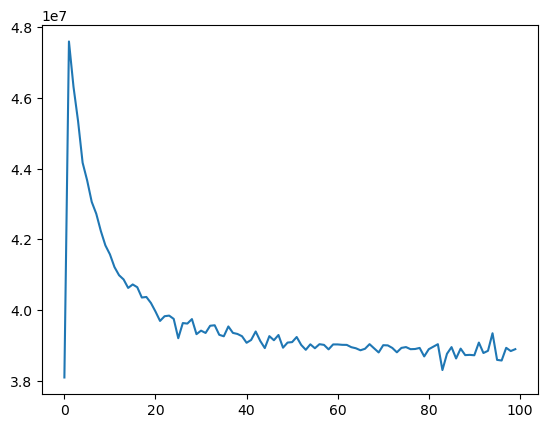

In [16]:
plt.plot(loss_list)

For comaprison, below is the loss plot when using default (larger) values for alpha. Note, that during training alpha is decreasing linearly from start value to end value. With default values in use the loss goes down near the end, once alpha gets smaller values.

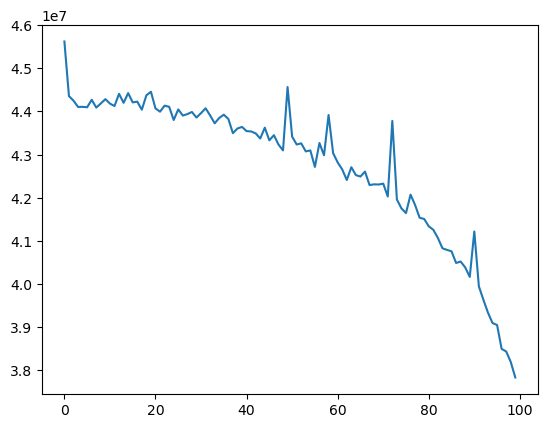

In [17]:
default_alpha_loss_list = [45621836.0, 44355904.0, 44249936.0, 44104492.0, 44107028.0, 44097436.0, 44270596.0, 44089604.0, 44185456.0, 44285424.0, 44182396.0, 44126032.0, 44408908.0, 44199988.0, 44425624.0, 44209516.0, 44227556.0, 44041368.0, 44373620.0, 44456688.0, 44070200.0, 43995008.0, 44134528.0, 44107632.0, 43802268.0, 44047244.0, 43904480.0, 43939264.0, 43987436.0, 43859148.0, 43961468.0, 44073332.0, 43907992.0, 43725336.0, 43849884.0, 43924944.0, 43826232.0, 43496588.0, 43605268.0, 43641544.0, 43543980.0, 43537204.0, 43491140.0, 43373268.0, 43624628.0, 43330720.0, 43449924.0, 43234040.0, 43097712.0, 44565932.0, 43416728.0, 43234072.0, 43260536.0, 43074152.0, 43096868.0, 42714596.0, 43268708.0, 42984456.0, 43917916.0, 43035192.0, 42818392.0, 42656488.0, 42411144.0, 42707748.0, 42523348.0, 42491780.0, 42605616.0, 42294312.0, 42310540.0, 42306532.0, 42327836.0, 42028380.0, 43780020.0, 41960848.0, 41753348.0, 41644528.0, 42072300.0, 41830796.0, 41535968.0, 41507712.0, 41336916.0, 41256888.0, 41069008.0, 40828812.0, 40791320.0, 40758012.0, 40487952.0, 40521400.0, 40385292.0, 40164828.0, 41217672.0, 39945608.0, 39633816.0, 39335348.0, 39096012.0, 39050096.0, 38497092.0, 38436708.0, 38193532.0, 37834140.0]
plt.plot(default_alpha_loss_list)

In [18]:
model.wv.most_similar('сабака', topn=20)

[('кошка', 0.8631081581115723),
 ('котка', 0.861184298992157),
 ('жывёліна', 0.8527911305427551),
 ('кот', 0.8515926003456116),
 ('дзік', 0.8432290554046631),
 ('кацяня', 0.840110719203949),
 ('пацук', 0.8306185007095337),
 ('конь', 0.8235841989517212),
 ('сабачка', 0.8149210214614868),
 ('воўк', 0.8096913695335388),
 ('шчанюк', 0.8085706830024719),
 ('муха', 0.8075309991836548),
 ('авечка', 0.8019874095916748),
 ('малпа', 0.8019631505012512),
 ('звер', 0.799534797668457),
 ('асёл', 0.7950820326805115),
 ('лісіца', 0.7932342886924744),
 ('мядзведзь', 0.7911040186882019),
 ('каза', 0.7823615074157715),
 ('зграя', 0.7814828157424927)]

In [19]:
model.wv.index_to_key[:10]

['быць',
 'год',
 'беларускі',
 'беларусь',
 'каль',
 'ала',
 'чалавек',
 'магчы',
 'час',
 'усё']

In [20]:
# tsne for visualization
# plotly for interactivity https://towardsdatascience.com/how-to-train-a-word2vec-model-from-scratch-with-gensim-c457d587e031
# save filtered out wods into separat file to verify
# dont explicitly list stop words
# prepare assessment data (50 words with 10 most similar wods for them)
# remove words after training
# increase corpus
# increase dimensionality

In [21]:
model.save("word2vec-100-bel-cc100.model")

INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'word2vec-100-bel-cc100.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-05T13:52:27.977904', 'gensim': '4.3.1', 'python': '3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]', 'platform': 'macOS-12.6-x86_64-i386-64bit', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved word2vec-100-bel-cc100.model


In [22]:
model.wv.save_word2vec_format('word2vec-100-bel-cc100.vectors')

INFO:gensim.models.keyedvectors:storing 78934x100 projection weights into word2vec-100-bel-cc100.vectors
